In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
test_df=pd.read_csv('test.csv')
train_df=pd.read_csv('train.csv')

In [31]:
train_df.select_dtypes(exclude='object').corr()['SalePrice'].sort_values()

KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
MSSubClass      -0.084284
OverallCond     -0.077856
YrSold          -0.028923
LowQualFinSF    -0.025606
Id              -0.021917
MiscVal         -0.021190
BsmtHalfBath    -0.016844
BsmtFinSF2      -0.011378
3SsnPorch        0.044584
MoSold           0.046432
PoolArea         0.092404
ScreenPorch      0.111447
BedroomAbvGr     0.168213
BsmtUnfSF        0.214479
BsmtFullBath     0.227122
LotArea          0.263843
HalfBath         0.284108
OpenPorchSF      0.315856
2ndFlrSF         0.319334
WoodDeckSF       0.324413
LotFrontage      0.351799
BsmtFinSF1       0.386420
Fireplaces       0.466929
MasVnrArea       0.477493
GarageYrBlt      0.486362
YearRemodAdd     0.507101
YearBuilt        0.522897
TotRmsAbvGrd     0.533723
FullBath         0.560664
1stFlrSF         0.605852
TotalBsmtSF      0.613581
GarageArea       0.623431
GarageCars       0.640409
GrLivArea        0.708624
OverallQual      0.790982
SalePrice        1.000000
Name: SalePr

Electrical         1
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtFinType2      38
BsmtExposure      38
GarageQual        81
GarageFinish      81
GarageYrBlt       81
GarageType        81
GarageCond        81
LotFrontage      259
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

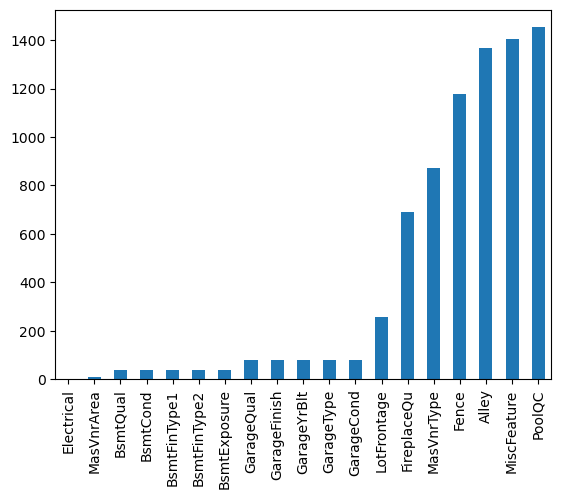

In [32]:
def misscheck(train_df):
    missing_values=train_df.isnull().sum().sort_values()
    missing_values=missing_values[missing_values>0]
    missing_values.plot(kind='bar')
    return missing_values
misscheck(train_df)

In [33]:
x=train_df.select_dtypes(include='object').isnull().sum()
x=x[x>0]
x.sort_values()

Electrical         1
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
BsmtExposure      38
BsmtFinType2      38
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
FireplaceQu      690
MasVnrType       872
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

In [34]:
object_tobe_filled=['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']

In [35]:

train_df = train_df.drop(columns=['MasVnrType', 'LotFrontage', 'Id','Electrical'])
test_df = test_df.drop(columns=['MasVnrType', 'LotFrontage','Electrical'])

In [36]:
#train_df['GarageYrBlt']=train_df['GarageYrBlt'].fillna(0)

In [37]:
#train_df['MasVnrArea']=train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].mean())
#train_df=train_df.drop(['MasVnrArea'],axis=1)

In [38]:
#train_df=train_df.dropna(subset=['Electrical'])

In [39]:


onehot_features = [
    'MSZoning', 'Street', 'Alley',  'LotConfig', 'Neighborhood',
    'Condition1', 'Condition2', 'BldgType','HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'CentralAir',
    'MiscFeature', 'SaleType', 'SaleCondition'
]

label_features = [
    'LotShape', 'LandContour','Utilities','LandSlope',  'ExterQual', 'ExterCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
    'KitchenQual',  'GarageType',
    'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual',
    'GarageCond', 'PavedDrive', 'PoolQC', 'Fence'
]

num_features = [ 'MSSubClass','OverallQual','OverallCond','LotArea','MasVnrArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1',
    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'
]
print(len(label_features+num_features+onehot_features))

76


In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# Categorical features with missing values filled with "None" and then one-hot encoded
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Ordinal encoded features — same fill with "None"
label_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Numeric features — fill with mean or 0
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # or 'constant', fill_value=0 if needed
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('onehot', onehot_transformer, onehot_features),
    ('label', label_transformer, label_features),
    ('numeric', numeric_transformer, num_features)
])

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
import numpy as np

# Prepare data
X = train_df.drop(columns=["SalePrice"])
y = train_df["SalePrice"]
y= np.log1p(y)

# Define pipeline without numeric scaling
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('model', xgb.XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42))
])

cv_scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse = -np.mean(cv_scores)



print(f"Cross-validated log-RMSE: {cv_rmse:.4f}")

Cross-validated log-RMSE: 0.1215


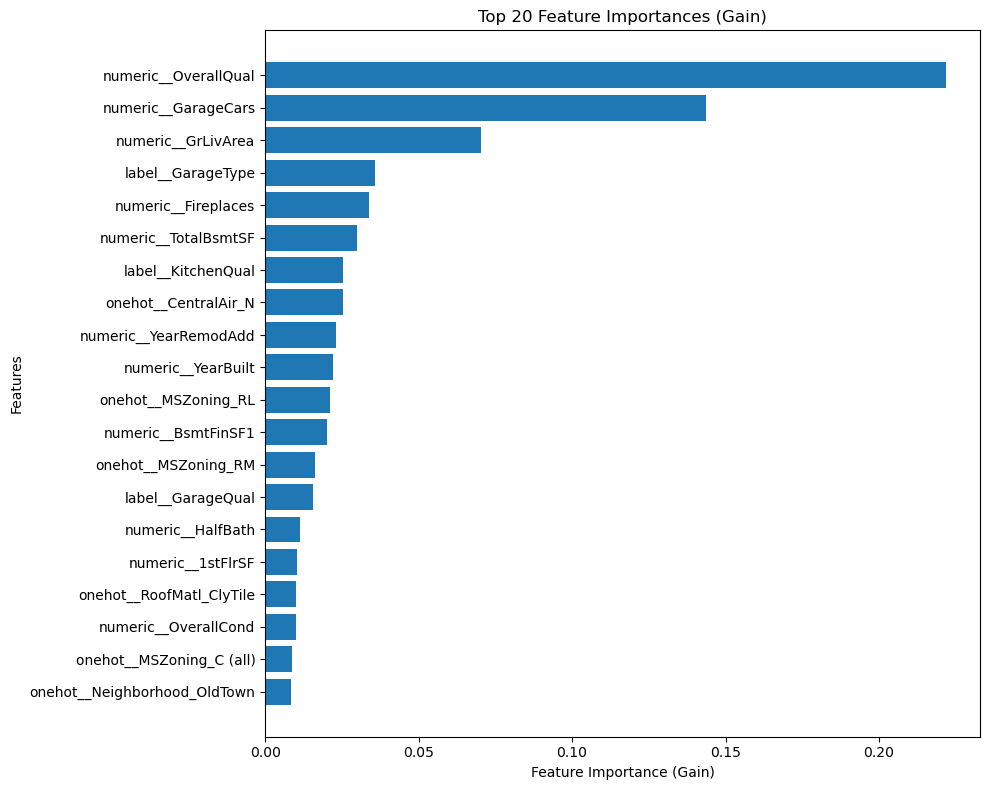

In [42]:
# Train model on full dataset
model_pipeline.fit(X, y)

# Get transformed feature names
preprocessor = model_pipeline.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Extract feature importances
booster = model_pipeline.named_steps['model']
importances = booster.feature_importances_

# Sort and select top N features
N = 20  # Choose the number of top features to display (adjust as needed)

sorted_idx = importances.argsort()[::-1]
top_N_idx = sorted_idx[:N]

top_N_importances = importances[top_N_idx]
top_N_feature_names = feature_names[top_N_idx] #Use the transformed names

# Plot the top N features
plt.figure(figsize=(10, 8))
plt.barh(top_N_feature_names, top_N_importances)
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Features")
plt.title(f"Top {N} Feature Importances (Gain)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [43]:
test_id=test_df['Id']
test_df=test_df.drop(columns=['Id'])

In [44]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotArea        1459 non-null   int64  
 3   Street         1459 non-null   object 
 4   Alley          107 non-null    object 
 5   LotShape       1459 non-null   object 
 6   LandContour    1459 non-null   object 
 7   Utilities      1457 non-null   object 
 8   LotConfig      1459 non-null   object 
 9   LandSlope      1459 non-null   object 
 10  Neighborhood   1459 non-null   object 
 11  Condition1     1459 non-null   object 
 12  Condition2     1459 non-null   object 
 13  BldgType       1459 non-null   object 
 14  HouseStyle     1459 non-null   object 
 15  OverallQual    1459 non-null   int64  
 16  OverallCond    1459 non-null   int64  
 17  YearBuilt      1459 non-null   int64  
 18  YearRemo

In [45]:
y_pred= model_pipeline.predict(test_df)
y_pred = np.expm1(y_pred)

In [46]:
submission_df = pd.DataFrame({
    'Id': test_id,  
    'SalePrice': y_pred   })

submission_df.to_csv('submission.csv', index=False)

In [47]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Id         1459 non-null   int64  
 1   SalePrice  1459 non-null   float32
dtypes: float32(1), int64(1)
memory usage: 17.2 KB
